In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
/kaggle/input/the-new-dalechall-familiar-words-list/DaleChallEasyWordList.txt


## Data

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore") 

In [3]:
## Libraries

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet 
import random
import spacy
import collections
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from keras import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

In [4]:
## Data Reading

train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv") 
id_1 = test['id'] 

In [5]:
train.drop(['url_legal','license','standard_error','id'],axis=1,inplace=True)
test.drop(['url_legal','license','id'],axis=1,inplace=True) 

In [6]:
X = train.drop('target',axis=1)
y = train.drop('excerpt',axis=1)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2) 

In [8]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

## Data Augmentation

In [9]:
def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [10]:
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence


In [11]:
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

In [12]:
def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)
    
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

In [13]:
def augment(no_of_word):
    aug = []
    t = []
    for r in range(len(X_train)):
        text = X_train['excerpt'][r]
        target_ = y_train['target'][r]
        aug.append(synonym_replacement(text, no_of_word)) 
        t.append(target_)
        aug.append(synonym_replacement(text, no_of_word)) 
        t.append(target_)
        aug.append(random_swap(text,no_of_word))
        t.append(target_)
        aug.append(random_insertion(text, no_of_word))
        t.append(target_)
    return aug,t

In [14]:
x,y = augment(4) 
data_x = pd.DataFrame({"excerpt":x})
data_y = pd.DataFrame({"target":y}) 

In [15]:
X_train = pd.concat([X_train,data_x])
y_train = pd.concat([y_train,data_y])

In [16]:
X_train.reset_index(inplace=True,drop = True)
y_train.reset_index(inplace=True,drop = True)

In [17]:
X_train

,excerpt
0,"Long, long, time ago, all the animals could ta..."
1,"The iron cylinder weighs 23 kilogrammes; but, ..."
2,"Frederick Fleet, who was lookout in the crow's..."
3,"In March of 1897, William McKinley was inaugur..."
4,"Long ago, there was a clever cat and a foolish..."
...,...
11330,But the sting certainly does not exhaust the w...
11331,"There has lately been held, at No. 31 Lombard ..."
11332,"There has lately been held, at No. 31 Lombard ..."
11333,"There has lately been held, at No. 31 Lombard ..."


In [18]:
y_train

,target
0,0.866330
1,-3.642892
2,-0.952409
3,-1.259490
4,0.653171
...,...
11330,-1.795783
11331,-1.949839
11332,-1.949839
11333,-1.949839


## POS 

In [19]:
X_train['word_count'] = X_train["excerpt"].apply(lambda x: len(str(x).split(" ")))
X_train['char_count'] = X_train["excerpt"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
X_train['sentence_count'] = X_train["excerpt"].apply(lambda x: len(str(x).split(".")))
X_train['avg_word_length'] = X_train['char_count'] / X_train['word_count']
X_train['avg_sentence_lenght'] = X_train['word_count'] / X_train['sentence_count']

X_test['word_count'] = X_test["excerpt"].apply(lambda x: len(str(x).split(" ")))
X_test['char_count'] = X_test["excerpt"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
X_test['sentence_count'] = X_test["excerpt"].apply(lambda x: len(str(x).split(".")))
X_test['avg_word_length'] = X_test['char_count'] / X_test['word_count']
X_test['avg_sentence_lenght'] = X_test['word_count'] / X_test['sentence_count'] 

test['word_count'] = test["excerpt"].apply(lambda x: len(str(x).split(" ")))
test['char_count'] = test["excerpt"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
test['sentence_count'] = test["excerpt"].apply(lambda x: len(str(x).split(".")))
test['avg_word_length'] = test['char_count'] / test['word_count']
test['avg_sentence_lenght'] = test['word_count'] / test['sentence_count'] 

In [20]:
X_train.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,"Long, long, time ago, all the animals could ta...",145,698,13,4.813793,11.153846


In [21]:
X_test.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,"In the 1980s, many people liked to use an oper...",165,813,14,4.927273,11.785714


In [22]:
test.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,My hope lay in Jack's promise that he would ke...,147,626,9,4.258503,16.333333


In [23]:
f = open("../input/the-new-dalechall-familiar-words-list/DaleChallEasyWordList.txt","r")
words = f.readlines()
f.close() 

In [24]:
def easy_words(string):
    c = 0
    for word in string.split():
        for i in range(len(words)):
            if word == words[i].strip():
                c = c + 1            
    return(c)
X_train['easy_words'] = X_train['excerpt'].apply(lambda x : easy_words(x))
X_test['easy_words'] = X_test['excerpt'].apply(lambda x : easy_words(x))    
test['easy_words'] = test['excerpt'].apply(lambda x : easy_words(x))    

In [25]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    c = 0
    if count >=3:
        c = c + 1
    return c
X_train['no_syllables'] = X_train['excerpt'].apply(lambda x : syllable_count(x))
X_test['no_syllables'] = X_test['excerpt'].apply(lambda x : syllable_count(x))
test['no_syllables'] = test['excerpt'].apply(lambda x : syllable_count(x))

In [26]:
X_train.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables
0,"Long, long, time ago, all the animals could ta...",145,698,13,4.813793,11.153846,74,1


In [27]:
X_test.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables
0,"In the 1980s, many people liked to use an oper...",165,813,14,4.927273,11.785714,90,1


In [28]:
test.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables
0,My hope lay in Jack's promise that he would ke...,147,626,9,4.258503,16.333333,114,1


In [29]:
ner = spacy.load('en_core_web_lg')  

X_train["tags"] = X_train["excerpt"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] ) 
X_test["tags"] = X_test["excerpt"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] ) 
test["tags"] = test["excerpt"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] ) 

In [30]:
X_train['pos'] = X_train['excerpt'].apply(lambda x : nltk.pos_tag(x,tagset = 'universal'))
X_test['pos'] = X_test['excerpt'].apply(lambda x : nltk.pos_tag(x,tagset = 'universal'))
test['pos'] = test['excerpt'].apply(lambda x : nltk.pos_tag(x,tagset = 'universal')) 

In [31]:
## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count 

In [32]:
## count tags
X_train["tags"] = X_train["tags"].apply(lambda x: utils_lst_count(x)) 
X_test["tags"] = X_test["tags"].apply(lambda x: utils_lst_count(x))
test["tags"] = test["tags"].apply(lambda x: utils_lst_count(x))
X_train["pos"] = X_train["pos"].apply(lambda x: utils_lst_count(x)) 
X_test["pos"] = X_test["pos"].apply(lambda x: utils_lst_count(x))
test["pos"] = test["pos"].apply(lambda x: utils_lst_count(x)) 

In [33]:
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0 

In [34]:
## extract features
tags_set = []
for lst in X_train["tags"].tolist():
     for dic in lst:
            for k in dic.keys():
                tags_set.append(k[1])
tags_set = list(set(tags_set))

pos_set = []
for lst in X_train["pos"].tolist():
     for dic in lst:
            for k in dic.keys():
                pos_set.append(k[1])
pos_set = list(set(pos_set))

In [35]:
for feature in tags_set:
     X_train["tags_"+feature] = X_train["tags"].apply(lambda x: 
                             utils_ner_features(x, feature)) 

for feature in tags_set:
     X_test["tags_"+feature] = X_test["tags"].apply(lambda x: 
                             utils_ner_features(x, feature)) 
for feature in tags_set:
     test["tags_"+feature] = test["tags"].apply(lambda x: 
                             utils_ner_features(x, feature)) 
print("pos")
        
for feature in pos_set:
     X_train["pos_"+feature] = X_train["pos"].apply(lambda x: 
                             utils_ner_features(x, feature)) 
for feature in pos_set:
     X_test["pos_"+feature] = X_test["pos"].apply(lambda x: 
                             utils_ner_features(x, feature)) 
for feature in pos_set:
     test["pos_"+feature] = test["pos"].apply(lambda x: 
                             utils_ner_features(x, feature))  

pos


In [36]:
X_train.head(1)

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables,tags,pos,...,pos_ADV,pos_NOUN,pos_PRT,pos_.,pos_ADP,pos_PRON,pos_VERB,pos_NUM,pos_X,pos_DET
0,"Long, long, time ago, all the animals could ta...",145,698,13,4.813793,11.153846,74,1,"[{('Baby Mosquito', 'PERSON'): 5}, {('One', 'C...","[{(' ', 'NOUN'): 115}, {('e', 'NOUN'): 72}, {(...",...,1,536,0,27,3,1,125,0,0,57


In [37]:
X_test.head(1) 

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables,tags,pos,...,pos_ADV,pos_NOUN,pos_PRT,pos_.,pos_ADP,pos_PRON,pos_VERB,pos_NUM,pos_X,pos_DET
0,"In the 1980s, many people liked to use an oper...",165,813,14,4.927273,11.785714,90,1,"[{('Linus Torvalds', 'PERSON'): 2}, {('Linus',...","[{(' ', 'NOUN'): 129}, {('e', 'NOUN'): 88}, {(...",...,0,666,0,19,12,10,118,8,1,52


In [38]:
test.head(1) 

,excerpt,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,easy_words,no_syllables,tags,pos,...,pos_ADV,pos_NOUN,pos_PRT,pos_.,pos_ADP,pos_PRON,pos_VERB,pos_NUM,pos_X,pos_DET
0,My hope lay in Jack's promise that he would ke...,147,626,9,4.258503,16.333333,114,1,"[{('Jack', 'PERSON'): 1}, {('a hundred yards',...","[{(' ', 'NOUN'): 110}, {('e', 'NOUN'): 53}, {(...",...,1,505,1,14,13,8,97,0,0,49


In [39]:
ps = WordNetLemmatizer()
corpus=[]
for i in range(0,len(X_train)):
    review_data = re.sub('[^a-zA-Z]',' ',X_train['excerpt'][i])    
    review_data = review_data.lower()
    review_data = review_data.split()
    
    review_data = [ps.lemmatize(word) for word in review_data if not word in stopwords.words('english')]
    review_data = " ".join(review_data)
    corpus.append(review_data)
X_train['excerpt'] = corpus

corpus=[]
for i in range(0,len(X_test)):
    review_data = re.sub('[^a-zA-Z]',' ',X_test['excerpt'][i])    
    review_data = review_data.lower()
    review_data = review_data.split()
    
    review_data = [ps.lemmatize(word) for word in review_data if not word in stopwords.words('english')]
    review_data = " ".join(review_data)
    corpus.append(review_data)
X_test['excerpt'] = corpus

corpus=[]
for i in range(0,len(test)):
    review_data = re.sub('[^a-zA-Z]',' ',test['excerpt'][i])    
    review_data = review_data.lower()
    review_data = review_data.split()
    
    review_data = [ps.lemmatize(word) for word in review_data if not word in stopwords.words('english')]
    review_data = " ".join(review_data)
    corpus.append(review_data)
test['excerpt'] = corpus 

## Gensim

In [40]:
glove_input_file = '../input/nlpword2vecembeddingspretrained/glove.6B.200d.txt'
word2vec_output_file = '/kaggle/working/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
filename = '/kaggle/working/glove.6B.100d.txt.word2vec'
nlp = KeyedVectors.load_word2vec_format(filename, binary=False)  

In [41]:
vector = []
for i in X_train['excerpt']:
    t = np.zeros(200)  
    for word in i.split():
        if word in nlp.key_to_index:
            t = t + nlp[word]
    t = t/len(i)
    vector.append(t)
    
X_train['vector'] = vector

vector = []
for i in X_test['excerpt']:
    t = np.zeros(200)  
    for word in i.split():
        if word in nlp.key_to_index:
            t = t + nlp[word]
    t = t/len(i)
    vector.append(t)
    
X_test['vector'] = vector

vector = []
for i in test['excerpt']:
    t = np.zeros(200)  
    for word in i.split():
        if word in nlp.key_to_index:
            t = t + nlp[word]
    t = t/len(i)
    vector.append(t)
    
test['vector'] = vector

In [42]:
tr = list(X_train['vector'])
dtr = pd.DataFrame(tr) 
X_train = X_train.join(dtr)

tv = list(X_test['vector'])
dtv = pd.DataFrame(tv)
X_test = X_test.join(dtv)

ts = list(test['vector'])
dts = pd.DataFrame(ts)
test = test.join(dts)

## Model

In [43]:
X_train.drop(['excerpt','tags','vector','pos'],axis=1,inplace=True)
X_test.drop(['excerpt','tags','vector','pos'],axis=1,inplace=True)
test.drop(['excerpt','tags','vector','pos'],axis=1,inplace=True) 

In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test) 

In [45]:
model_reg = LinearRegression()
model_reg.fit(X_train,y_train) 
pred = model_reg.predict(X_test) 
mean_squared_error(y_test,pred) 

0.49406964036980944

In [46]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train) 
pred = model_xgb.predict(X_test) 
mean_squared_error(y_test,pred) 

0.5268753649364666

In [47]:
model_tree = DecisionTreeRegressor()
model_tree.fit(X_train,y_train)
pred = model_tree.predict(X_test)
mean_squared_error(y_test,pred) 

1.023787323763595

In [48]:
model_lgb = LGBMRegressor()
model_lgb.fit(X_train,y_train)
pred = model_lgb.predict(X_test)
mean_squared_error(y_test,pred)

0.4595270226640616

In [49]:
model_gbm = GradientBoostingRegressor()
model_gbm.fit(X_train,y_train)
pred = model_gbm.predict(X_test)
mean_squared_error(y_test,pred)

0.44918026991172716

In [50]:
model = Sequential()
#model.add(LSTM(128,input_dim = X_train.shape[1],activation = 'relu'))
model.add(Dense(128,input_dim = X_train.shape[1],activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(1,activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               30464     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 96,641
Trainable params: 96,641
Non-trainable params: 0
____________________________________________________

In [51]:
history = model.fit(X_train,y_train,epochs = 15,validation_split = 0.2) 

Epoch 1/15
284/284 [==============================] - 2s 5ms/step - loss: 0.5541 - val_loss: 0.3438
Epoch 2/15
284/284 [==============================] - 1s 3ms/step - loss: 0.1400 - val_loss: 0.2373
Epoch 3/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0646 - val_loss: 0.1254
Epoch 4/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0398 - val_loss: 0.1044
Epoch 5/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0306 - val_loss: 0.0796
Epoch 6/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0276 - val_loss: 0.0566
Epoch 7/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0487
Epoch 8/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0495
Epoch 9/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0591
Epoch 10/15
284/284 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0495

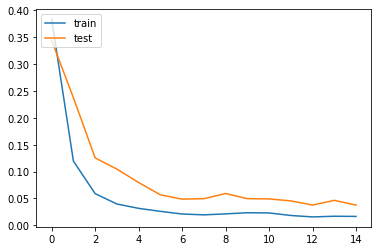

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')  

In [53]:
mean_squared_error(y_test,model.predict(X_test))

0.47839817142068136

In [54]:
pred = model.predict(test) 

In [55]:
pred.shape

(7, 1)

In [56]:
np.reshape(pred,(7,)).shape

(7,)

In [57]:
output = pd.DataFrame({'id': id_1, 'target':np.reshape(pred,(7,))})

output.to_csv("/kaggle/working/submission.csv",index=False)

In [58]:
output

,id,target
0,c0f722661,-0.779540
1,f0953f0a5,-0.200166
2,0df072751,-0.550690
3,04caf4e0c,-2.372612
4,0e63f8bea,-1.415827
5,12537fe78,-0.711374
6,965e592c0,0.928718
